# Analisis SARIMA untuk Prediksi Pengiriman Paket

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from itertools import product
import json
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

print("Libraries berhasil dimuat!")
print("Notebook untuk perbandingan SARIMA vs Prophet")

Libraries berhasil dimuat!
Notebook untuk perbandingan SARIMA vs Prophet


In [2]:
# Load Data
df = pd.read_excel("../data/data_kiriman.xlsx")

# Data Preprocessing
df = df[['Kota', 'Cek', 'Tgl_Kirim']]
df['Kecamatan'] = df['Kota'].apply(lambda x: x.split(',')[1].strip() if len(x.split(',')) > 1 else '')
df = df[['Kecamatan', 'Cek', 'Tgl_Kirim']]

# Agregasi mingguan per kecamatan
df_kecamatan_weekly = df.groupby('Kecamatan').resample('W', on='Tgl_Kirim')['Cek'].count().reset_index()
df_kecamatan_weekly.rename(columns={'Cek': 'total paket'}, inplace=True)
df_kecamatan_weekly['minggu_ke'] = df_kecamatan_weekly['Tgl_Kirim'].dt.isocalendar().week.astype(int)

unique_kecamatan = df_kecamatan_weekly['Kecamatan'].unique()

print("Data berhasil dimuat!")
print(f"Total Kecamatan: {len(unique_kecamatan)}")
print(f"Kecamatan: {', '.join(unique_kecamatan)}")
print(f"\nTotal data: {len(df_kecamatan_weekly)} minggu")
display(df_kecamatan_weekly.head(10))

Data berhasil dimuat!
Total Kecamatan: 5
Kecamatan: BLIMBING, KEDUNGKANDANG, KLOJEN, LOWOKWARU, SUKUN

Total data: 1050 minggu


,Kecamatan,Tgl_Kirim,total paket,minggu_ke
0,BLIMBING,2020-12-27,7,52
1,BLIMBING,2021-01-03,217,53
2,BLIMBING,2021-01-10,518,1
3,BLIMBING,2021-01-17,432,2
4,BLIMBING,2021-01-24,446,3
5,BLIMBING,2021-01-31,423,4
6,BLIMBING,2021-02-07,550,5
7,BLIMBING,2021-02-14,323,6
8,BLIMBING,2021-02-21,546,7
9,BLIMBING,2021-02-28,531,8


## Uji Stasioneritas Data (ADF Test)

In [36]:
print("Uji Stasioneritas Data (Augmented Dickey-Fuller Test)")
print("="*70)

stationarity_results = {}

for kecamatan in unique_kecamatan:
    df_filtered = df_kecamatan_weekly[df_kecamatan_weekly['Kecamatan'] == kecamatan].copy()
    df_filtered = df_filtered.set_index('Tgl_Kirim')
    
    adf_result = adfuller(df_filtered['total paket'])
    
    stationarity_results[kecamatan] = {
        'ADF Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Stasioner': 'Ya' if adf_result[1] < 0.05 else 'Tidak'
    }
    
    print(f"\nKecamatan: {kecamatan}")
    print(f"   ADF Statistic: {adf_result[0]:.4f}")
    print(f"   p-value: {adf_result[1]:.4f}")
    print(f"   Stasioner: {stationarity_results[kecamatan]['Stasioner']}")

stationarity_df = pd.DataFrame(stationarity_results).T
display(stationarity_df)

Uji Stasioneritas Data (Augmented Dickey-Fuller Test)

Kecamatan: BLIMBING
   ADF Statistic: -4.6987
   p-value: 0.0001
   Stasioner: Ya

Kecamatan: KEDUNGKANDANG
   ADF Statistic: -2.6662
   p-value: 0.0801
   Stasioner: Tidak

Kecamatan: KLOJEN
   ADF Statistic: -2.5952
   p-value: 0.0940
   Stasioner: Tidak

Kecamatan: LOWOKWARU
   ADF Statistic: -2.1869
   p-value: 0.2110
   Stasioner: Tidak

Kecamatan: SUKUN
   ADF Statistic: -10.4351
   p-value: 0.0000
   Stasioner: Ya


,ADF Statistic,p-value,Stasioner
BLIMBING,-4.69867,0.000085,Ya
KEDUNGKANDANG,-2.666223,0.080068,Tidak
KLOJEN,-2.595163,0.094001,Tidak
LOWOKWARU,-2.186885,0.21104,Tidak
SUKUN,-10.435125,0.0,Ya


## SARIMA - Grid Search untuk Optimasi Parameter

Grid Search untuk menemukan parameter SARIMA terbaik (p,d,q)(P,D,Q,s)

In [49]:
print("Memulai Grid Search SARIMA untuk Optimasi Hyperparameter")
print("="*70)

# Define parameter ranges untuk SARIMA (Grid Search Lengkap)
# p, d, q: order ARIMA
# P, D, Q, s: seasonal order (s=52 untuk data mingguan/tahunan)
p = d = q = range(0, 3)  # 0, 1, 2
P = D = Q = range(0, 2)  # 0, 1
s = 52  # seasonality periode (52 minggu)

# Generate semua kombinasi
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in product(P, D, Q)]

print(f"Total kombinasi SARIMA yang akan diuji: {len(pdq) * len(seasonal_pdq)}")
print(f"pdq kombinasi: {len(pdq)}")
print(f"seasonal_pdq kombinasi: {len(seasonal_pdq)}\n") 

sarima_results = {}

for kecamatan in unique_kecamatan:
    print(f"\n{'='*70}")
    print(f"Optimasi SARIMA untuk Kecamatan: {kecamatan}")
    print(f"{'='*70}")
    
    # Filter dan split data
    df_filtered = df_kecamatan_weekly[df_kecamatan_weekly['Kecamatan'] == kecamatan].copy()
    split_point = len(df_filtered) - 52
    
    train = df_filtered.iloc[:split_point].copy()
    test = df_filtered.iloc[split_point:].copy()
    
    # Set index untuk time series
    train = train.set_index('Tgl_Kirim')
    test = test.set_index('Tgl_Kirim')
    
    best_mape = float('inf')
    best_order = None
    best_seasonal_order = None
    best_model = None
    
    tested = 0
    total_tests = len(pdq) * len(seasonal_pdq)
    
    # Grid Search
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            tested += 1
            try:
                # Fit SARIMA model
                model = SARIMAX(train['total paket'],
                               order=param,
                               seasonal_order=param_seasonal,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
                
                results = model.fit(disp=False)
                
                # Prediksi
                predictions = results.forecast(steps=52)
                
                # Evaluasi
                y_true = test['total paket'].values
                y_pred = predictions.values
                
                mape = mean_absolute_percentage_error(y_true, y_pred) * 100
                
                # Update best model
                if mape < best_mape:
                    best_mape = mape
                    best_order = param
                    best_seasonal_order = param_seasonal
                    best_model = results
                    print(f"✨ [{tested}/{total_tests}] MAPE Terbaik Baru: {mape:.2f}% - SARIMA{param}x{param_seasonal}")
                
                # Print progress setiap 10 iterasi
                if tested % 10 == 0:
                    print(f"   Progress: {tested}/{total_tests} kombinasi diuji... (Best MAPE: {best_mape:.2f}%)")
                    
            except Exception as e:
                print(f"Error - SARIMA{param}x{param_seasonal}")
                continue
    
    mae = mean_absolute_error(test['total paket'].values, best_model.forecast(steps=52).values)
    rmse = np.sqrt(mean_squared_error(test['total paket'].values, best_model.forecast(steps=52).values))
    
    sarima_results[kecamatan] = {
        'order': best_order,
        'seasonal_order': best_seasonal_order,
        'train': train,
        'test': test,
        'model': best_model,
        'predictions': best_model.forecast(steps=52),
        'metrics': {
            'MAPE': best_mape,
            'MAE': mae,
            'RMSE': rmse
        }
    }
    
    # Status berdasarkan MAPE
    if best_mape < 10:
        status = "Sangat Baik"
    elif best_mape < 20:
        status = "Baik"
    elif best_mape < 50:
        status = "Cukup"
    else:
        status = "Buruk"
    
    print(f"\n{'='*70}")
    print(f"HASIL OPTIMASI SARIMA - {kecamatan}")
    print(f"{'='*70}")
    print(f"Best Order (p,d,q): {best_order}")
    print(f"Best Seasonal Order (P,D,Q,s): {best_seasonal_order}")
    print(f"MAPE: {best_mape:.2f}% - {status}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

# Summary hasil SARIMA
print(f"\n{'='*70}")
print("RINGKASAN HASIL SARIMA - SEMUA KECAMATAN")
print(f"{'='*70}\n")

sarima_summary = pd.DataFrame({
    kec: {
        'MAPE': res['metrics']['MAPE'],
        'MAE': res['metrics']['MAE'],
        'RMSE': res['metrics']['RMSE'],
        'order': str(res['order']),
        'seasonal_order': str(res['seasonal_order'])
    } for kec, res in sarima_results.items()
}).T

display(sarima_summary)
print(f"\nRata-rata MAPE SARIMA: {sarima_summary['MAPE'].mean():.2f}%")

Memulai Grid Search SARIMA untuk Optimasi Hyperparameter
Total kombinasi SARIMA yang akan diuji: 216
pdq kombinasi: 27
seasonal_pdq kombinasi: 8


Optimasi SARIMA untuk Kecamatan: BLIMBING
✨ [1/216] MAPE Terbaik Baru: 100.00% - SARIMA(0, 0, 0)x(0, 0, 0, 52)
✨ [1/216] MAPE Terbaik Baru: 100.00% - SARIMA(0, 0, 0)x(0, 0, 0, 52)
✨ [2/216] MAPE Terbaik Baru: 100.00% - SARIMA(0, 0, 0)x(0, 0, 1, 52)
✨ [3/216] MAPE Terbaik Baru: 21.12% - SARIMA(0, 0, 0)x(0, 1, 0, 52)
✨ [2/216] MAPE Terbaik Baru: 100.00% - SARIMA(0, 0, 0)x(0, 0, 1, 52)
✨ [3/216] MAPE Terbaik Baru: 21.12% - SARIMA(0, 0, 0)x(0, 1, 0, 52)
✨ [5/216] MAPE Terbaik Baru: 18.39% - SARIMA(0, 0, 0)x(1, 0, 0, 52)
✨ [5/216] MAPE Terbaik Baru: 18.39% - SARIMA(0, 0, 0)x(1, 0, 0, 52)
✨ [6/216] MAPE Terbaik Baru: 12.06% - SARIMA(0, 0, 0)x(1, 0, 1, 52)
✨ [6/216] MAPE Terbaik Baru: 12.06% - SARIMA(0, 0, 0)x(1, 0, 1, 52)
   Progress: 10/216 kombinasi diuji... (Best MAPE: 12.06%)
   Progress: 10/216 kombinasi diuji... (Best MAPE: 12.06%)
✨ [14/216

,MAPE,MAE,RMSE,order,seasonal_order
BLIMBING,11.516427,103.230858,149.334157,"(2, 1, 0)","(1, 0, 1, 52)"
KEDUNGKANDANG,8.354278,56.357098,73.511976,"(0, 1, 2)","(1, 1, 0, 52)"
KLOJEN,9.637389,202.371248,250.458648,"(0, 1, 1)","(1, 1, 0, 52)"
LOWOKWARU,11.034148,122.889218,176.81043,"(2, 2, 2)","(1, 1, 0, 52)"
SUKUN,12.978384,124.90132,310.596165,"(0, 1, 2)","(1, 1, 0, 52)"



Rata-rata MAPE SARIMA: 10.70%


## Prophet Dengan Holiday

In [53]:
# Prophet DENGAN Holiday Parameter
print("Menjalankan Prophet DENGAN parameter holiday Indonesia")
print("="*70)

# Optimal params dari notebook prophet
optimal_params = {
    'KEDUNGKANDANG': {
        'changepoint_prior_scale': 1.0,
        'seasonality_prior_scale': 0.1,
        'seasonality_mode': 'additive',
        'n_changepoints': 150
    },
    'SUKUN': {
        'changepoint_prior_scale': 0.05,
        'seasonality_prior_scale': 0.01,
        'seasonality_mode': 'multiplicative',
        'n_changepoints': 10
    },
    'BLIMBING': {
        'changepoint_prior_scale': 1.0,
        'seasonality_prior_scale': 0.5,
        'seasonality_mode': 'additive',
        'n_changepoints': 50
    },
    'LOWOKWARU': {
        'changepoint_prior_scale': 1.0,
        'seasonality_prior_scale': 0.05,
        'seasonality_mode': 'additive',
        'n_changepoints': 75
    },
    'KLOJEN': {
        'changepoint_prior_scale': 0.001,
        'seasonality_prior_scale': 0.05,
        'seasonality_mode': 'multiplicative',
        'n_changepoints': 100
    }
}

# Buat holidays Indonesia
holidays = make_holidays_df(
    year_list=[2021, 2022, 2023, 2024, 2025],
    country='ID'
)

prophet_results = {}

for kecamatan in unique_kecamatan:
    print(f"\nMemproses: {kecamatan}")
    
    # Filter dan split data
    df_filtered = df_kecamatan_weekly[df_kecamatan_weekly['Kecamatan'] == kecamatan].copy()
    split_point = len(df_filtered) - 52
    
    train = df_filtered.iloc[:split_point].copy()
    test = df_filtered.iloc[split_point:].copy()
    
    # Prepare data untuk Prophet
    train_prophet = train[['Tgl_Kirim', 'total paket']].copy()
    train_prophet.columns = ['ds', 'y']
    
    # Get optimal params
    params = optimal_params.get(kecamatan, {
        'changepoint_prior_scale': 0.5,
        'seasonality_prior_scale': 1.0,
        'seasonality_mode': 'additive',
        'n_changepoints': 25
    })
    
    # Prophet DENGAN holidays
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        holidays=holidays,  # DENGAN HOLIDAY INDONESIA!
        **params
    )
    
    model.fit(train_prophet)
    
    # Prediksi
    future = model.make_future_dataframe(periods=52, freq='W')
    forecast = model.predict(future)
    test_predictions = forecast.tail(52)
    
    # Evaluasi
    y_true = test['total paket'].values
    y_pred = test_predictions['yhat'].values
    
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    prophet_results[kecamatan] = {
        'train': train,
        'test': test,
        'predictions': test_predictions,
        'metrics': {
            'MAPE': mape,
            'MAE': mae,
            'RMSE': rmse
        }
    }
    
    print(f"   MAPE Prophet (dengan holiday): {mape:.2f}%")

# Summary Prophet dengan holiday
print(f"\n{'='*70}")
print("RINGKASAN PROPHET DENGAN HOLIDAY")
print(f"{'='*70}\n")

prophet_summary = pd.DataFrame({
    kec: res['metrics'] for kec, res in prophet_results.items()
}).T

display(prophet_summary)
print(f"\nRata-rata MAPE Prophet (dengan holiday): {prophet_summary['MAPE'].mean():.2f}%")

Menjalankan Prophet DENGAN parameter holiday Indonesia

Memproses: BLIMBING


14:55:14 - cmdstanpy - INFO - Chain [1] start processing
14:55:14 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] done processing


   MAPE Prophet (dengan holiday): 10.25%

Memproses: KEDUNGKANDANG


14:55:15 - cmdstanpy - INFO - Chain [1] start processing
14:55:15 - cmdstanpy - INFO - Chain [1] done processing
14:55:15 - cmdstanpy - INFO - Chain [1] done processing


   MAPE Prophet (dengan holiday): 9.06%

Memproses: KLOJEN


14:55:15 - cmdstanpy - INFO - Chain [1] start processing
14:55:15 - cmdstanpy - INFO - Chain [1] done processing
14:55:15 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:55:15 - cmdstanpy - INFO - Chain [1] done processing
14:55:15 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:55:15 - cmdstanpy - INFO - Chain [1] start processing
14:55:15 - cmdstanpy - INFO - Chain [1] start processing
14:55:20 - cmdstanpy - INFO - Chain [1] done processing
14:55:20 - cmdstanpy - INFO - Chain [1] done processing


   MAPE Prophet (dengan holiday): 8.51%

Memproses: LOWOKWARU


14:55:20 - cmdstanpy - INFO - Chain [1] start processing
14:55:20 - cmdstanpy - INFO - Chain [1] done processing
14:55:20 - cmdstanpy - INFO - Chain [1] done processing


   MAPE Prophet (dengan holiday): 8.50%

Memproses: SUKUN


14:55:21 - cmdstanpy - INFO - Chain [1] start processing
14:55:21 - cmdstanpy - INFO - Chain [1] done processing
14:55:21 - cmdstanpy - INFO - Chain [1] done processing


   MAPE Prophet (dengan holiday): 12.04%

RINGKASAN PROPHET DENGAN HOLIDAY



,MAPE,MAE,RMSE
BLIMBING,10.250906,98.945941,188.934558
KEDUNGKANDANG,9.059368,62.686820,93.798350
KLOJEN,8.509465,170.787152,213.135821
LOWOKWARU,8.498803,98.272087,126.489585
SUKUN,12.041288,137.653200,471.646311



Rata-rata MAPE Prophet (dengan holiday): 9.67%


## PERBANDINGAN HASIL: SARIMA vs Prophet (Dengan Holiday)

In [55]:
print("="*80)
print("PERBANDINGAN MAPE - SARIMA vs PROPHET (DENGAN HOLIDAY)")
print("="*80)

comparison_data = {}

for kecamatan in unique_kecamatan:
    sarima_mape = sarima_results[kecamatan]['metrics']['MAPE']
    prophet_mape = prophet_results[kecamatan]['metrics']['MAPE']
    
    # Hitung selisih
    difference = sarima_mape - prophet_mape
    difference_pct = (difference / sarima_mape) * 100 if sarima_mape != 0 else 0
    
    comparison_data[kecamatan] = {
        'SARIMA_MAPE': sarima_mape,
        'Prophet_MAPE': prophet_mape,
        'Selisih': difference,
        'Selisih_%': difference_pct,
        'Metode_Terbaik': 'SARIMA' if sarima_mape < prophet_mape else 'Prophet'
    }

comparison_df = pd.DataFrame(comparison_data).T
comparison_df = comparison_df.round(2)

display(comparison_df)

PERBANDINGAN MAPE - SARIMA vs PROPHET (DENGAN HOLIDAY)


,SARIMA_MAPE,Prophet_MAPE,Selisih,Selisih_%,Metode_Terbaik
BLIMBING,11.516427,10.250906,1.265521,10.988832,Prophet
KEDUNGKANDANG,8.354278,9.059368,-0.705089,-8.439858,SARIMA
KLOJEN,9.637389,8.509465,1.127924,11.703628,Prophet
LOWOKWARU,11.034148,8.498803,2.535344,22.977257,Prophet
SUKUN,12.978384,12.041288,0.937096,7.220436,Prophet


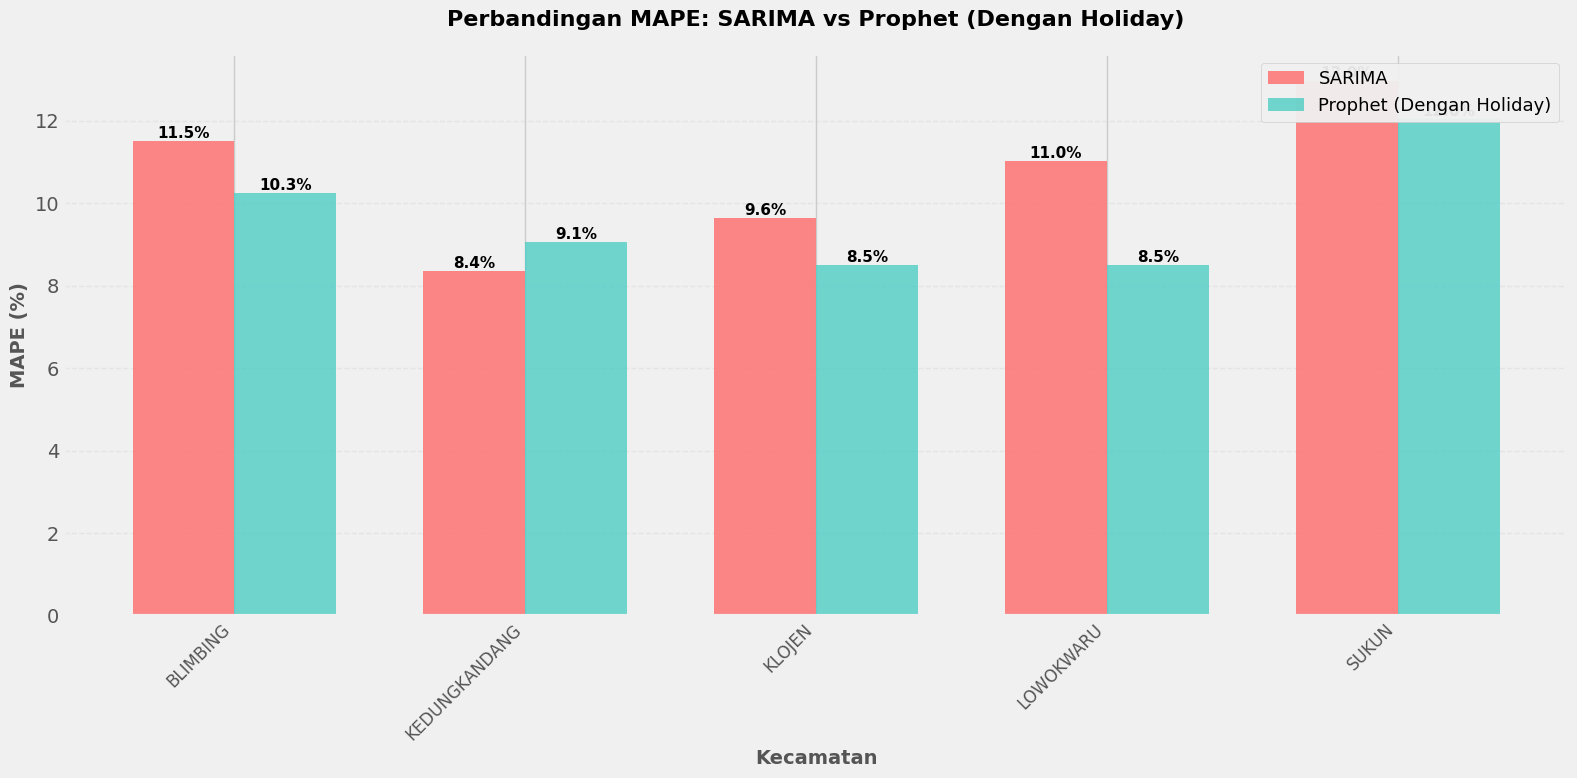


Detail Perbandingan per Kecamatan:
BLIMBING:
   SARIMA: 11.52% | Prophet: 10.25% | Selisih: 1.27 poin
KEDUNGKANDANG:
   SARIMA: 8.35% | Prophet: 9.06% | Selisih: 0.71 poin
KLOJEN:
   SARIMA: 9.64% | Prophet: 8.51% | Selisih: 1.13 poin
LOWOKWARU:
   SARIMA: 11.03% | Prophet: 8.50% | Selisih: 2.54 poin
SUKUN:
   SARIMA: 12.98% | Prophet: 12.04% | Selisih: 0.94 poin


In [56]:
fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(unique_kecamatan))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['SARIMA_MAPE'], width, 
                label='SARIMA', color='#FF6B6B', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Prophet_MAPE'], width, 
                label='Prophet (Dengan Holiday)', color='#4ECDC4', alpha=0.8)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Kecamatan', fontsize=14, fontweight='bold')
ax.set_ylabel('MAPE (%)', fontsize=14, fontweight='bold')
ax.set_title('Perbandingan MAPE: SARIMA vs Prophet (Dengan Holiday)', 
              fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(unique_kecamatan, rotation=45, ha='right', fontsize=12)
ax.legend(loc='upper right', fontsize=13, framealpha=0.95)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.show()

# Detail per Kecamatan
print(f"\nDetail Perbandingan per Kecamatan:")
print("="*80)
for kec in unique_kecamatan:
    sarima = comparison_df.loc[kec, 'SARIMA_MAPE']
    prophet = comparison_df.loc[kec, 'Prophet_MAPE']
    selisih = comparison_df.loc[kec, 'Selisih']
    
    print(f"{kec}:")
    print(f"   SARIMA: {sarima:.2f}% | Prophet: {prophet:.2f}% | Selisih: {abs(selisih):.2f} poin")